## Imports

In [32]:
%pylab inline
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

## Data loading & cleaning

In [79]:
from helper import clean_data
from helper import vix_prime_combine

In [80]:
pct_df, vix_close , prime, weekly_vix, monthly_vix = clean_data()
monthly_vix = pct_df.resample('M').sum()
vp_df = vix_prime_combine(monthly_vix,prime)

In [81]:
pct_df['prime'] = prime
pct_df.prime = pct_df.prime.fillna(method='ffill')
pct_df.prime = pct_df.prime.fillna(value=10)
weekly_pct = pct_df.resample('W').mean()

In [82]:
##create train & validation sets
df_len = weekly_pct.shape[0]
train_vix = weekly_pct.iloc[:df_len-52*4,0].values
train_prime = weekly_pct.iloc[:df_len-52*4,1].values
validation = weekly_pct.iloc[df_len-52*4:df_len-52*2,0].values
validation_prime = weekly_pct.iloc[df_len-52*4-1:df_len-52*2-1,0].values
test = weekly_pct.iloc[df_len-52*2:,0]

In [36]:
#from helper import split_data

In [37]:
# df_len = pct_df.shape[0]
# train = pct_df.iloc[:df_len-200,0]
# train = train.values
# validation = pct_df.iloc[df_len-200:df_len-100,0]
# validation = validation.values
# test = pct_df.iloc[df_len-100:,0]

In [83]:
def RMSE(validation_points, prediction_points):
   """
   Calculate RMSE between two vectors
   """
   x = np.array(validation_points)
   y = np.array(prediction_points)

   return np.sqrt(np.mean((x - y)**2))


In [84]:
train = train_vix

In [85]:
model = ARIMA(train, order=(1,0,0)).fit()
preds = model.forecast(52*2)[0]
RMSE(validation,preds)


/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

0.03999091368878814

In [91]:
def test_model(df,p,q):
    preds = []
    df = list(df)

    for i in validation:
        model = ARIMA(df, order=(p,0,q)).fit()
        pred = model.forecast()[0][0]
        preds.append(pred)
        df.append(i)

    plt.plot(validation)
    plt.plot(preds)
    rmse = RMSE(validation,np.array(preds))
    print(rmse)
    
    return rmse,validation,preds


/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

0.0394839772927842


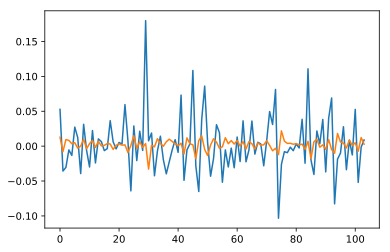

In [92]:
ans = test_model(train,1,0)

In [94]:
df_dict = {'validation':ans[1],'predictions':ans[2]}
graph_df = pd.DataFrame.from_dict(df_dict)

In [95]:
graph_df.head()

,validation,predictions
0,0.052743,0.012777
1,-0.035689,-0.007698
2,-0.030369,0.009411
3,-0.005424,0.008289
4,-0.013307,0.003462


In [90]:
%config InlineBackend.figure_format = 'svg'

In [121]:
x = weekly_pct.iloc[df_len-52*4:df_len-52*2,1].index

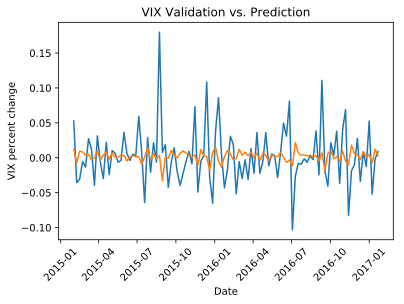

In [125]:

a = sns.lineplot(x=x, y='validation',data=graph_df, ci=None)
a = sns.lineplot(x=x, y='predictions',data=graph_df, ci=None).set_title('VIX Validation vs. Prediction')
plt.xlabel('Date')
plt.ylabel('VIX percent change')
plt.xticks(rotation=45)

figure = a.get_figure()
figure.savefig('results.svg')

In [ ]:
res= []
for p in range(1,7):
    for q in range(2):
        res.append([p,q,test_model(train,p,q)])
        
res

In [73]:
#results from the cell above (I ran in Kaggle and it timed out after 7)
pq_grid_optimization = [[1, 0, 0.037839233218272914],
 [1, 1, 0.03847912428054359],
 [2, 0, 0.03788305122017626],
 [2, 1, 0.038499309176399224],
 [3, 0, 0.037925153396494535],
 [3, 1, 0.038543161054074446],
 [4, 0, 0.038051414961248364],
 [4, 1, 0.03848483521462794],
 [5, 0, 0.03830419265953073],
 [5, 1, 0.03845494151848534],
 [6, 0, 0.03805082071951061]]

In [75]:
pq_grid_optimization_df = pd.DataFrame(pq_grid_optimization)
pq_grid_optimization_df.to_csv('pqres.csv')

In [89]:
res= []
for i in range(1,):
    for q in range(1,2):
        model = ARIMA(train,order=(i,0,0)).fit().forecast(52*2)
        res.append([i,q,RMSE(validation,model[0])])
        
res

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

[[1, 1, 0.03999091368878814],
 [2, 1, 0.040001620645448835],
 [3, 1, 0.040008036128782634],
 [4, 1, 0.04001874112480024]]